In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import label_ranking_average_precision_score,average_precision_score,precision_recall_curve

Matplotlib created a temporary config/cache directory at /home/tomita/.cache/matplotlib because the default path (/tmp/matplotlib-pl87tdsw) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [6]:
with open(os.path.join('test_results','test_result_merged1and2.json'),'r') as f:
    results = json.load(f)

In [3]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def mean_average_precision(y_true, y_pred):
    average_precisions = []
    # クラス単位でAPを計算
    for i in range(len(y_true)):
        sort_idx = np.argsort(y_pred[i])[::-1]
        y_true_sorted = y_true[i][sort_idx]

        cumsum = np.cumsum(y_true_sorted)
        recall = cumsum / np.max(cumsum)
        precision = cumsum / np.arange(1, 1 + y_true[i].shape[0])

        # 代表点
        points_x = np.arange(11) / 10
        points_y = np.zeros(points_x.shape[0])
        for i in range(points_x.shape[0]-1, -1, -1):
            points_y[i] = np.max(precision[recall >= points_x[i]])

        average_precision = np.mean(points_y)
        average_precisions.append(average_precision)
    return average_precisions

# IoUとｍAPの計算

In [4]:
result_files = ['test_result_merged1and2.json','test_result_part1.json','test_result_part2.json']
#result_files = ['test_result_part1.json']

mAPs = {}
for rf in result_files:
    print('>'*50)
    print(rf)
    print('<'*50)
    with open(os.path.join('test_results',rf),'r') as f:
        results = json.load(f)
    
    mAPs[rf] = []
    AP = {}
    
    for thresh_rate in range(1,8):
        total_AP = 0
        for i,target in enumerate(results.keys()):
            print(i,target)
            partial = results[target]
            partial_true = partial["ground truth"]
            partial_predict = partial["prediction"]
            true_bbox = []
            for t in partial_true:
                true_bbox.append(
                    [
                        t["bbox"]["left"],
                        t["bbox"]["top"],
                        t["bbox"]["right"],
                        t["bbox"]["bottom"]
                    ]
                )

            predict_bbox = []
            predict_score = []
            for t in partial_predict:
                predict_bbox.append(
                    [
                        t["bbox"]["left"],
                        t["bbox"]["top"],
                        t["bbox"]["right"],
                        t["bbox"]["bottom"],
                    ]
                )
                predict_score.append(t["score"])

            iou = []
            score = []
            for tb in true_bbox:
                for j,pb in enumerate(predict_bbox):
                    print("iou:",bb_intersection_over_union(tb,pb),"score:",predict_score[j])
                    iou.append(bb_intersection_over_union(tb,pb))
                    score.append(predict_score[j])
            iou = np.array(iou)
            iou = np.where(iou > (thresh_rate*0.1), True, False)
            score = np.array(score)
            precision, recall, threshold = precision_recall_curve(iou[::-1],score[::-1])
            print("precision:",precision)
            print("recall:",recall)
            print("threshold:",threshold)
            #print(iou,score)
            #print(average_precision_score(iou,score))
            #AP[target] = average_precision_score(iou,score)
            total_AP += average_precision_score(iou,score)

        mAPs[rf].append(total_AP/len(results.keys()))

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
test_result_merged1and2.json
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
0 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2251.jpg
iou: 0.5472193365740704 score: 0.05304333567619324
iou: 0.4773297303753247 score: 0.07140480726957321
iou: 0.44342918570276807 score: 0.09118080139160156
iou: 0.4471538335319003 score: 0.37531939148902893
precision: [1. 1. 1. 1. 1.]
recall: [1.   0.75 0.5  0.25 0.  ]
threshold: [0.05304334 0.07140481 0.0911808  0.37531939]
1 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_143.jpg
iou: 0.06390069486608649 score: 0.12041126936674118
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.12041127]
2 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1788.jpg
iou: 0 score: 0.05513797327876091
iou: 0.053708137507020186 score: 0.34773746132850647
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.34773746]
3 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8823.jpg
iou: 0.4836284153005

39 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2230.jpg
iou: 0.33106430115595575 score: 0.1555202752351761
iou: 0.16585152360632419 score: 0.33807480335235596
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.15552028 0.3380748 ]
40 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_376.jpg
iou: 0.17906841901816775 score: 0.07742828130722046
iou: 0.31793957993037336 score: 0.1597110778093338
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.07742828 0.15971108]
41 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_148.jpg
iou: 0.47524204518176727 score: 0.12229210138320923
iou: 0.3144451551712729 score: 0.4149101674556732
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.1222921  0.41491017]
42 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9348.jpg
iou: 0.1490707555007002 score: 0.0574956052005291
iou: 0.2298973067235032 score: 0.07295618206262589
iou: 0.15128421135121367 score: 0.07446763664484024
iou: 0.18429025345451858 score: 

23 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1858.jpg
iou: 0.29004491017964074 score: 0.12642399966716766
iou: 0.6899669239250276 score: 0.2808946371078491
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.126424   0.28089464]
24 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_5399.jpg
iou: 0.4867432433423007 score: 0.06671834737062454
iou: 0.49473546214776587 score: 0.0870366021990776
iou: 0.1489092899856818 score: 0.09623688459396362
iou: 0.17797447225561433 score: 0.10986003279685974
iou: 0.6080333520404073 score: 0.11273884773254395
precision: [0.6        0.5        0.33333333 0.5        1.         1.        ]
recall: [1.         0.66666667 0.33333333 0.33333333 0.33333333 0.        ]
threshold: [0.06671835 0.0870366  0.09623688 0.10986003 0.11273885]
25 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10371.jpg
iou: 0.5348440696881394 score: 0.12729313969612122
iou: 0.14866354367594378 score: 0.1756575107574463
iou: 0.3123484072656713 score: 0.

iou: 0.48362841530054645 score: 0.07332634925842285
iou: 0.45148372808880777 score: 0.1589190661907196
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.07332635 0.15891907]
4 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_6784.jpg
iou: 0.5083038962408394 score: 0.06899864971637726
iou: 0.35065719897265446 score: 0.2928367555141449
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.06899865 0.29283676]
5 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9227.jpg
iou: 0.6500442529300804 score: 0.06745389848947525
iou: 0.18227009113504558 score: 0.07163510471582413
iou: 0.4549400180503585 score: 0.11791689693927765
iou: 0.34477291107989616 score: 0.1661246120929718
iou: 0.5945424632665797 score: 0.2050270289182663
precision: [0.8  0.75 1.   1.   1.   1.  ]
recall: [1.   0.75 0.75 0.5  0.25 0.  ]
threshold: [0.0674539  0.0716351  0.1179169  0.16612461 0.20502703]
6 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4525.jpg
iou: 0.07740576593970776 score

iou: 0.1477304764589794 score: 0.0947989970445633
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.094799]
38 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_3315.jpg
iou: 0.18442394804344267 score: 0.07890108972787857
iou: 0.31438617793630314 score: 0.13437236845493317
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.13437237]
39 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2230.jpg
iou: 0.33106430115595575 score: 0.1555202752351761
iou: 0.16585152360632419 score: 0.33807480335235596
precision: [0.5 0.  1. ]
recall: [1. 0. 0.]
threshold: [0.15552028 0.3380748 ]
40 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_376.jpg
iou: 0.17906841901816775 score: 0.07742828130722046
iou: 0.31793957993037336 score: 0.1597110778093338
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.15971108]
41 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_148.jpg
iou: 0.47524204518176727 score: 0.12229210138320923
iou: 0.3144451551712729 score: 0.4149101674556732
precision: [1.

23 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1858.jpg
iou: 0.29004491017964074 score: 0.12642399966716766
iou: 0.6899669239250276 score: 0.2808946371078491
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.28089464]
24 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_5399.jpg
iou: 0.4867432433423007 score: 0.06671834737062454
iou: 0.49473546214776587 score: 0.0870366021990776
iou: 0.1489092899856818 score: 0.09623688459396362
iou: 0.17797447225561433 score: 0.10986003279685974
iou: 0.6080333520404073 score: 0.11273884773254395
precision: [0.6        0.5        0.33333333 0.5        1.         1.        ]
recall: [1.         0.66666667 0.33333333 0.33333333 0.33333333 0.        ]
threshold: [0.06671835 0.0870366  0.09623688 0.10986003 0.11273885]
25 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10371.jpg
iou: 0.5348440696881394 score: 0.12729313969612122
iou: 0.14866354367594378 score: 0.1756575107574463
iou: 0.3123484072656713 score: 0.3946332037448883
pre

iou: 0.053708137507020186 score: 0.34773746132850647
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.34773746]
3 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8823.jpg
iou: 0.48362841530054645 score: 0.07332634925842285
iou: 0.45148372808880777 score: 0.1589190661907196
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.15891907]
4 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_6784.jpg
iou: 0.5083038962408394 score: 0.06899864971637726
iou: 0.35065719897265446 score: 0.2928367555141449
precision: [0.5 0.  1. ]
recall: [1. 0. 0.]
threshold: [0.06899865 0.29283676]
5 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9227.jpg
iou: 0.6500442529300804 score: 0.06745389848947525
iou: 0.18227009113504558 score: 0.07163510471582413
iou: 0.4549400180503585 score: 0.11791689693927765
iou: 0.34477291107989616 score: 0.1661246120929718
iou: 0.5945424632665797 score: 0.2050270289182663
precision: [0.4        0.25       0.33333333 0.5        1.         1.        ]
recall: [1

precision: [0. 1.]
recall: [0. 0.]
threshold: [0.19438276]
35 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_189.jpg
iou: 0.4247201476447557 score: 0.05074483901262283
iou: 0.17943156743300076 score: 0.06391984969377518
iou: 0.34514214755644707 score: 0.07545120269060135
iou: 0 score: 0.05074483901262283
iou: 0 score: 0.06391984969377518
iou: 0.20514618857668873 score: 0.07545120269060135
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.0754512]
36 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_429.jpg
iou: 0.3247128230740417 score: 0.055524542927742004
iou: 0.17763024291181753 score: 0.0628243237733841
iou: 0.42635419130624647 score: 0.24616765975952148
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.24616766]
37 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1100.jpg
iou: 0.19179842156322924 score: 0.07606770843267441
iou: 0.1722282023681378 score: 0.08432972431182861
iou: 0.1477304764589794 score: 0.0947989970445633
precision: [0. 1.]
recall: [0. 0.]
thre

48 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_59.jpg
iou: 0.3121132217618253 score: 0.05684497579932213
iou: 0.446461746326634 score: 0.09582705050706863
iou: 0.8950448692937963 score: 0.17056916654109955
iou: 0.5204377212745414 score: 0.4079798758029938
precision: [0.5 0.  1. ]
recall: [1. 0. 0.]
threshold: [0.17056917 0.40797988]
49 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_5800.jpg
iou: 0.41789434891643373 score: 0.05505034700036049
iou: 0.2842881760226819 score: 0.12368127703666687
iou: 0.21335167515775835 score: 0.5296875834465027
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.52968758]
50 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_11404.jpg
iou: 0.433723706867847 score: 0.07816580682992935
iou: 0.28968824027475193 score: 0.08233138173818588
iou: 0.3715478896532975 score: 0.12114723771810532
iou: 0.4023431054397448 score: 0.3925977349281311
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.39259773]
0 /home/tomita/keras-yolo3/use_images/n02

28 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9915.jpg
iou: 0.2606043956043956 score: 0.15027321875095367
iou: 0.28413499402035997 score: 0.24472676217556
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.24472676]
29 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_7272.jpg
iou: 0.40675829266196123 score: 0.19313330948352814
iou: 0.20875010872401495 score: 0.2949294447898865
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.29492944]
30 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4857.jpg
iou: 0.28509658755093786 score: 0.0909724161028862
iou: 0.14832695046954564 score: 0.0916956290602684
iou: 0.4715683961304705 score: 0.21026602387428284
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.21026602]
31 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10982.jpg
iou: 0.18435258964143425 score: 0.116729237139225
iou: 0.3803990311666525 score: 0.14621853828430176
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.14621854]
32 /home/tomita/keras-yolo3/use_im

precision: [1. 1. 1. 1. 1.]
recall: [1.   0.75 0.5  0.25 0.  ]
threshold: [0.07322522 0.08808908 0.18005955 0.25537676]
12 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_7500.jpg
iou: 0.6202317842032209 score: 0.2282528132200241
iou: 0.2057468571874756 score: 0.2296358197927475
iou: 0.2989170746180092 score: 0.2441985160112381
precision: [1. 1. 1. 1.]
recall: [1.         0.66666667 0.33333333 0.        ]
threshold: [0.22825281 0.22963582 0.24419852]
13 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10506.jpg
iou: 0.6241113567118705 score: 0.07835953682661057
iou: 0.37385461209529625 score: 0.45939549803733826
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.07835954 0.4593955 ]
14 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8472.jpg
iou: 0.3104308390022676 score: 0.054760370403528214
iou: 0.3537609133646743 score: 0.05558039993047714
iou: 0.5423257802479692 score: 0.21581041812896729
iou: 0.2526220940710038 score: 0.26838555932044983
precision: [1

iou: 0 score: 0.11785746365785599
iou: 0.004782602156682859 score: 0.12311102449893951
precision: [0.6   0.625 0.5   0.5   0.5   1.   ]
recall: [1.         0.83333333 0.5        0.33333333 0.16666667 0.        ]
threshold: [0.0589759  0.07253819 0.0972705  0.11785746 0.12311102]
36 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_429.jpg
iou: 0.22686089197844256 score: 0.053775884211063385
iou: 0.2811763514197927 score: 0.14863328635692596
iou: 0.47087576103120143 score: 0.28193721175193787
iou: 0.5947934761629029 score: 0.30949515104293823
precision: [1. 1. 1. 1. 1.]
recall: [1.   0.75 0.5  0.25 0.  ]
threshold: [0.05377588 0.14863329 0.28193721 0.30949515]
37 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1100.jpg
iou: 0.12557339449541285 score: 0.05145326629281044
iou: 0.14376637963309621 score: 0.11385945230722427
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.05145327 0.11385945]
38 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_3315.jpg
iou: 0.

precision: [1. 1. 1. 1. 1. 1.]
recall: [1.  0.8 0.6 0.4 0.2 0. ]
threshold: [0.09023488 0.09394173 0.14514561 0.25280666 0.54127687]
9 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9508.jpg
iou: 0.061064012777982554 score: 0.050062134861946106
iou: 0.28038505632085603 score: 0.06199875473976135
iou: 0.5083424883273826 score: 0.12986226379871368
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.06199875 0.12986226]
10 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10829.jpg
iou: 0.26508778056446236 score: 0.0646655485033989
iou: 0.5485183033120279 score: 0.08322307467460632
iou: 0.33552386066789847 score: 0.13890674710273743
iou: 0.3171327294210319 score: 0.21845798194408417
iou: 0.5714503322607056 score: 0.283812552690506
precision: [1. 1. 1. 1. 1. 1.]
recall: [1.  0.8 0.6 0.4 0.2 0. ]
threshold: [0.06466555 0.08322307 0.13890675 0.21845798 0.28381255]
11 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_5700.jpg
iou: 0.1651463725074247 score: 0.0732252

precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.11684759 0.23252217]
39 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2230.jpg
iou: 0.13688897309586964 score: 0.12249938398599625
iou: 0.07504086636697997 score: 0.1437644064426422
iou: 0.08575710576303086 score: 0.15092208981513977
iou: 0.20894839917521504 score: 0.15971657633781433
iou: 0.11166698664016533 score: 0.20128482580184937
iou: 0.06451893774488464 score: 0.4099815785884857
precision: [0.33333333 0.         0.         1.        ]
recall: [1. 0. 0. 0.]
threshold: [0.15971658 0.20128483 0.40998158]
40 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_376.jpg
iou: 0.24850232970934102 score: 0.06968482583761215
iou: 0.22442828839114812 score: 0.21694761514663696
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.06968483 0.21694762]
41 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_148.jpg
iou: 0.2297587561112447 score: 0.07831589132547379
iou: 0.2825564632388275 score: 0.08116069436073303

iou: 0.45399332470043224 score: 0.12646076083183289
iou: 0.17573217271986621 score: 0.5348659753799438
precision: [0.4        0.25       0.33333333 0.5        0.         1.        ]
recall: [1.  0.5 0.5 0.5 0.  0. ]
threshold: [0.06766556 0.0863378  0.10221469 0.12646076 0.53486598]
21 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2322.jpg
iou: 0.1464968152866242 score: 0.09475800395011902
iou: 0.6607862903225806 score: 0.10591961443424225
iou: 0.23852908891328212 score: 0.3617691993713379
precision: [0.5 0.  1. ]
recall: [1. 0. 0.]
threshold: [0.10591961 0.3617692 ]
22 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10201.jpg
iou: 0.1916145414008794 score: 0.06864521652460098
iou: 0.1672263201465951 score: 0.13475555181503296
iou: 0.2206309773166415 score: 0.5893803834915161
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.58938038]
23 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1858.jpg
iou: 0.3101828657314629 score: 0.0979900136590004
iou: 0.41806583862

50 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_11404.jpg
iou: 0.2505303815893372 score: 0.056092794984579086
iou: 0.26491490110642835 score: 0.06373917311429977
iou: 0.21786303435924023 score: 0.06595000624656677
iou: 0.2591061762898487 score: 0.07524551451206207
iou: 0.508281665548433 score: 0.11982136219739914
iou: 0.24807130150273102 score: 0.14220772683620453
iou: 0.42537715721780595 score: 0.4849695861339569
precision: [0.66666667 0.5        1.         1.        ]
recall: [1.  0.5 0.5 0. ]
threshold: [0.11982136 0.14220773 0.48496959]
0 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2251.jpg
iou: 0.35403487872367695 score: 0.059543427079916
iou: 0.2631852118018126 score: 0.06185179576277733
iou: 0.39385155906895036 score: 0.19787320494651794
iou: 0.4489583256892516 score: 0.22485311329364777
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.22485311]
1 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_143.jpg
iou: 0 score: 0.05174333229660988
iou: 0.07243

28 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9915.jpg
iou: 0.46792816956692396 score: 0.08005568385124207
iou: 0.33288882650196516 score: 0.16949114203453064
iou: 0.27025597525073597 score: 0.2808223366737366
precision: [0.33333333 0.         0.         1.        ]
recall: [1. 0. 0. 0.]
threshold: [0.08005568 0.16949114 0.28082234]
29 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_7272.jpg
iou: 0.20198826798394567 score: 0.08963742107152939
iou: 0.35893268454167454 score: 0.13886743783950806
iou: 0.2590072995436614 score: 0.206650510430336
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.20665051]
30 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4857.jpg
iou: 0.3128303064108988 score: 0.0576905831694603
iou: 0.23823534273293773 score: 0.057758353650569916
iou: 0.48659719565168463 score: 0.07538328319787979
iou: 0.3611206585058474 score: 0.17680491507053375
precision: [0.5 0.  1. ]
recall: [1. 0. 0.]
threshold: [0.07538328 0.17680492]
31 /home/tomita/ker

threshold: [0.38593978]
5 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9227.jpg
iou: 0.14911023024373787 score: 0.06581926345825195
iou: 0.6411988180666948 score: 0.06667675822973251
iou: 0.338994594134423 score: 0.07106629759073257
iou: 0.5954418002732044 score: 0.07963316887617111
iou: 0.15978163708338655 score: 0.08220728486776352
precision: [0.5        0.33333333 0.5        0.         1.        ]
recall: [1.  0.5 0.5 0.  0. ]
threshold: [0.06667676 0.0710663  0.07963317 0.08220728]
6 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4525.jpg
iou: 0.06305239986283337 score: 0.11585666984319687
iou: 0.39707447721731964 score: 0.31986871361732483
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.31986871]
7 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4030.jpg
iou: 0.27289390200916464 score: 0.06451171636581421
iou: 0.355982905982906 score: 0.12644916772842407
iou: 0.35521213824107895 score: 0.12752752006053925
iou: 0.1981468215066737 score: 0.48810261487960

precision: [0.1 0.  0.  0.  0.  1. ]
recall: [1. 0. 0. 0. 0. 0.]
threshold: [0.0589759  0.07253819 0.0972705  0.11785746 0.12311102]
36 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_429.jpg
iou: 0.22686089197844256 score: 0.053775884211063385
iou: 0.2811763514197927 score: 0.14863328635692596
iou: 0.47087576103120143 score: 0.28193721175193787
iou: 0.5947934761629029 score: 0.30949515104293823
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.30949515]
37 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1100.jpg
iou: 0.12557339449541285 score: 0.05145326629281044
iou: 0.14376637963309621 score: 0.11385945230722427
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.11385945]
38 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_3315.jpg
iou: 0.40180138920693076 score: 0.11684758961200714
iou: 0.4116413630107868 score: 0.2325221747159958
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.23252217]
39 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2230.jpg
iou: 0

threshold: [0.28381255]
11 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_5700.jpg
iou: 0.1651463725074247 score: 0.07322521507740021
iou: 0.45370183578777484 score: 0.08808907866477966
iou: 0.27735632072827776 score: 0.180059552192688
iou: 0.40412305781595664 score: 0.25537675619125366
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.25537676]
12 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_7500.jpg
iou: 0.6202317842032209 score: 0.2282528132200241
iou: 0.2057468571874756 score: 0.2296358197927475
iou: 0.2989170746180092 score: 0.2441985160112381
precision: [0.33333333 0.         0.         1.        ]
recall: [1. 0. 0. 0.]
threshold: [0.22825281 0.22963582 0.24419852]
13 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10506.jpg
iou: 0.6241113567118705 score: 0.07835953682661057
iou: 0.37385461209529625 score: 0.45939549803733826
precision: [0.5 0.  1. ]
recall: [1. 0. 0.]
threshold: [0.07835954 0.4593955 ]
14 /home/tomita/keras-yolo3/use_images/n02231487/n

38 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_3315.jpg
iou: 0.40180138920693076 score: 0.11684758961200714
iou: 0.4116413630107868 score: 0.2325221747159958
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.23252217]
39 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2230.jpg
iou: 0.13688897309586964 score: 0.12249938398599625
iou: 0.07504086636697997 score: 0.1437644064426422
iou: 0.08575710576303086 score: 0.15092208981513977
iou: 0.20894839917521504 score: 0.15971657633781433
iou: 0.11166698664016533 score: 0.20128482580184937
iou: 0.06451893774488464 score: 0.4099815785884857
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.40998158]
40 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_376.jpg
iou: 0.24850232970934102 score: 0.06968482583761215
iou: 0.22442828839114812 score: 0.21694761514663696
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.21694762]
41 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_148.jpg
iou: 0.2297587561112447 score: 0.0783

16 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_473.jpg
iou: 0.2830811069423111 score: 0.060997944325208664
iou: 0.40244449667727944 score: 0.35045140981674194
iou: 0.41705902618282037 score: 0.3526732325553894
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.35267323]
17 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_12685.jpg
iou: 0.09364025213867627 score: 0.05758102983236313
iou: 0.33738246643839337 score: 0.10384093225002289
iou: 0.141411828932191 score: 0.4945387542247772
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.49453875]
18 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_6008.jpg
iou: 0.2407982706045726 score: 0.06052219122648239
iou: 0.2529802467005952 score: 0.0666758194565773
iou: 0.10159264428207865 score: 0.07060009241104126
iou: 0.08686727999120332 score: 0.15444163978099823
iou: 0.0739083924924633 score: 0.20103147625923157
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.20103148]
19 /home/tomita/keras-yolo3/use_images/n02231487/n02231

threshold: [0.20156166]
47 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10120.jpg
iou: 0.1985995347189055 score: 0.05761617049574852
iou: 0.26339022394733336 score: 0.08852241933345795
iou: 0.19275740336833586 score: 0.10378983616828918
iou: 0.22002555704067095 score: 0.34351974725723267
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.34351975]
48 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_59.jpg
iou: 0.25700404858299597 score: 0.052315328270196915
iou: 0.5377955377955378 score: 0.0695778876543045
iou: 0.36677634832609085 score: 0.08055940270423889
iou: 0.2768421052631579 score: 0.13324852287769318
iou: 0.37750822049038135 score: 0.1918000727891922
iou: 0.7035973397823458 score: 0.2175498753786087
iou: 0.5837731711670364 score: 0.6768893599510193
precision: [0.5 0.  1. ]
recall: [1. 0. 0.]
threshold: [0.21754988 0.67688936]
49 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_5800.jpg
iou: 0.23302425889147466 score: 0.11201624572277069
iou: 0.119450469992

precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.23735072 0.43892449]
29 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_7272.jpg
iou: 0.3666107908961338 score: 0.10240843892097473
iou: 0.2580280678782247 score: 0.4842154383659363
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.10240844 0.48421544]
30 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4857.jpg
iou: 0.15593389310484113 score: 0.08343426138162613
iou: 0.3495951118963486 score: 0.13120205700397491
iou: 0.6638695019080136 score: 0.3949858248233795
precision: [1. 1. 1. 1.]
recall: [1.         0.66666667 0.33333333 0.        ]
threshold: [0.08343426 0.13120206 0.39498582]
31 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10982.jpg
iou: 0.37000064167789604 score: 0.06226309761404991
iou: 0.14685570658141975 score: 0.06840834021568298
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.0622631  0.06840834]
32 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10352.jpg
iou: 0

7 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4030.jpg
iou: 0.374479992817167 score: 0.06061692535877228
iou: 0.38297485610421084 score: 0.0620083324611187
iou: 0.30625 score: 0.351427286863327
precision: [1. 1. 1. 1.]
recall: [1.         0.66666667 0.33333333 0.        ]
threshold: [0.06061693 0.06200833 0.35142729]
8 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1002.jpg
iou: 0.31536605664231615 score: 0.16190557181835175
iou: 0.48074766084622006 score: 0.5716009736061096
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.16190557 0.57160097]
9 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9508.jpg
iou: 0.6628300885678136 score: 0.06113957613706589
iou: 0.10674994676698134 score: 0.07923799008131027
iou: 0.2693395505274423 score: 0.1693916916847229
precision: [0.66666667 0.5        1.         1.        ]
recall: [1.  0.5 0.5 0. ]
threshold: [0.06113958 0.07923799 0.16939169]
10 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10829.jpg
io

precision: [0.66666667 0.5        1.         1.        ]
recall: [1.  0.5 0.5 0. ]
threshold: [0.05450426 0.06332825 0.21070413]
39 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2230.jpg
iou: 0.06741070430095503 score: 0.05249355733394623
iou: 0.35368680496464305 score: 0.11117526143789291
iou: 0.22903297189643726 score: 0.2987022399902344
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.11117526 0.29870224]
40 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_376.jpg
iou: 0.1715423829639837 score: 0.06603103131055832
iou: 0.20145853134243508 score: 0.2540627419948578
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.25406274]
41 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_148.jpg
iou: 0.20814004171985429 score: 0.053490087389945984
iou: 0.21140965833572228 score: 0.054932430386543274
iou: 0.3361244273995952 score: 0.6251701712608337
precision: [1. 1. 1. 1.]
recall: [1.         0.66666667 0.33333333 0.        ]
threshold: [0.05349009 0.05493243 0.625

19 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_12911.jpg
iou: 0.28552937563073144 score: 0.07132750749588013
iou: 0.19076726044941203 score: 0.15236657857894897
iou: 0.3316176232559645 score: 0.32161977887153625
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.32161978]
20 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2106.jpg
iou: 0.3130767349298468 score: 0.05960098281502724
iou: 0.42039270155944186 score: 0.1338568776845932
iou: 0.29311410036788454 score: 0.26256251335144043
precision: [0.66666667 0.5        0.         1.        ]
recall: [1.  0.5 0.  0. ]
threshold: [0.05960098 0.13385688 0.26256251]
21 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2322.jpg
iou: 0.6356563592008967 score: 0.08254583179950714
iou: 0.2120373069076071 score: 0.23174132406711578
precision: [0.5 0.  1. ]
recall: [1. 0. 0.]
threshold: [0.08254583 0.23174132]
22 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10201.jpg
iou: 0.06926603539140494 score: 0.18772108852863

iou: 0.2646127411314572 score: 0.38140028715133667
precision: [0.5 0.  1. ]
recall: [1. 0. 0.]
threshold: [0.15810409 0.38140029]
5 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9227.jpg
iou: 0.37200442685055124 score: 0.05114439129829407
iou: 0.3948729408760056 score: 0.14966990053653717
iou: 0.5781633428956555 score: 0.4024820327758789
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.40248203]
6 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4525.jpg
iou: 0.1857732029822969 score: 0.5805739164352417
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.58057392]
7 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4030.jpg
iou: 0.374479992817167 score: 0.06061692535877228
iou: 0.38297485610421084 score: 0.0620083324611187
iou: 0.30625 score: 0.351427286863327
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.35142729]
8 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1002.jpg
iou: 0.31536605664231615 score: 0.16190557181835175
iou: 0.48074766084622006 score:

recall: [0. 0.]
threshold: [0.29870224]
40 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_376.jpg
iou: 0.1715423829639837 score: 0.06603103131055832
iou: 0.20145853134243508 score: 0.2540627419948578
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.25406274]
41 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_148.jpg
iou: 0.20814004171985429 score: 0.053490087389945984
iou: 0.21140965833572228 score: 0.054932430386543274
iou: 0.3361244273995952 score: 0.6251701712608337
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.62517017]
42 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9348.jpg
iou: 0.07558469251185264 score: 0.05338897928595543
iou: 0.1310742500063505 score: 0.07837756723165512
iou: 0.12516603755554495 score: 0.09061907231807709
iou: 0.06659500887933452 score: 0.1310865879058838
iou: 0.14245187436676798 score: 0.13289670646190643
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.13289671]
43 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8677.j

recall: [1.         0.66666667 0.66666667 0.33333333 0.        ]
threshold: [0.13530222 0.16576859 0.21931495 0.34181815]
4 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_6784.jpg
iou: 0.2875384251596122 score: 0.06241346895694733
iou: 0.49302748665216534 score: 0.1581040918827057
iou: 0.2646127411314572 score: 0.38140028715133667
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.38140029]
5 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9227.jpg
iou: 0.37200442685055124 score: 0.05114439129829407
iou: 0.3948729408760056 score: 0.14966990053653717
iou: 0.5781633428956555 score: 0.4024820327758789
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.40248203]
6 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4525.jpg
iou: 0.1857732029822969 score: 0.5805739164352417
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.58057392]
7 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4030.jpg
iou: 0.374479992817167 score: 0.06061692535877228
iou: 0.38297485610421084 sc

42 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9348.jpg
iou: 0.07558469251185264 score: 0.05338897928595543
iou: 0.1310742500063505 score: 0.07837756723165512
iou: 0.12516603755554495 score: 0.09061907231807709
iou: 0.06659500887933452 score: 0.1310865879058838
iou: 0.14245187436676798 score: 0.13289670646190643
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.13289671]
43 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8677.jpg
iou: 0.22917978050849777 score: 0.07313764840364456
iou: 0.5664845173041895 score: 0.1250016838312149
iou: 0.2687305118942239 score: 0.4732450544834137
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.47324505]
44 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_3491.jpg
iou: 0.26799638377217766 score: 0.07476567476987839
iou: 0.23261773247537157 score: 0.16456985473632812
iou: 0.2727673730449007 score: 0.33230096101760864
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.33230096]
45 /home/tomita/keras-yolo3/use_images/n02231487/n0223

recall: [1. 0. 0.]
threshold: [0.37928203 0.45458671]
49 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_5800.jpg
iou: 0.47043572445907567 score: 0.07240501791238785
iou: 0.27493433868638606 score: 0.13348113000392914
iou: 0.2779393003133055 score: 0.5503572821617126
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.55035728]
50 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_11404.jpg
iou: 0.3114363928023434 score: 0.06820515543222427
iou: 0.4723202648578197 score: 0.09003204852342606
iou: 0.38683835343637557 score: 0.6367415189743042
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.63674152]


In [5]:
mAPs

{'test_result_merged1and2.json': [0.9513888888888888,
  0.8166666666666667,
  0.661437908496732,
  0.425599128540305,
  0.22777777777777777,
  0.12156862745098039,
  0.0392156862745098],
 'test_result_part1.json': [0.930751633986928,
  0.7800108932461874,
  0.5796486928104575,
  0.3833333333333333,
  0.219281045751634,
  0.08006535947712418,
  0.029411764705882353],
 'test_result_part2.json': [0.9569716775599129,
  0.794967320261438,
  0.5723039215686274,
  0.37908496732026137,
  0.24346405228758172,
  0.1323529411764706,
  0.029411764705882353]}

[0.9513888888888888, 0.8166666666666667, 0.661437908496732, 0.425599128540305, 0.22777777777777777, 0.12156862745098039, 0.0392156862745098]
[0.930751633986928, 0.7800108932461874, 0.5796486928104575, 0.3833333333333333, 0.219281045751634, 0.08006535947712418, 0.029411764705882353]
[0.9569716775599129, 0.794967320261438, 0.5723039215686274, 0.37908496732026137, 0.24346405228758172, 0.1323529411764706, 0.029411764705882353]


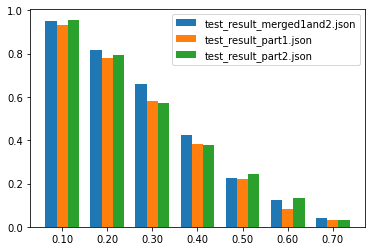

In [47]:
thresh_rate_values = [1, 2, 3, 4, 5, 6, 7]
graph_labels = ["{:.2f}".format(i*0.1) for i in thresh_rate_values]
bar_width = 0.25

for i,file in enumerate(mAPs.keys()):
    print(mAPs[file])
    plt.bar(np.array(thresh_rate_values)+bar_width*i,mAPs[file],width=bar_width,label=file,align="center")
    #ax.grid(axis='both')
plt.legend()
plt.xticks(np.array(thresh_rate_values) + bar_width, graph_labels)
plt.show()

In [46]:
graph_labels

['0.100', '0.200', '0.300', '0.400', '0.500', '0.600', '0.700']

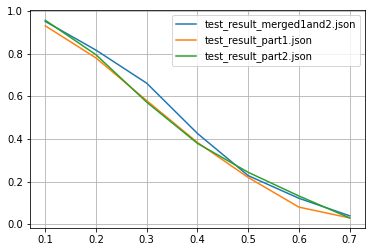

In [27]:
thresh_rate_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
fig = plt.figure()
ax = fig.add_subplot(111)

for file in mAPs.keys():
    ax.plot(thresh_rate_values,mAPs[file],label=file)
ax.grid(axis='both')
ax.legend()

In [104]:
AP

{'/home/tomita/keras-yolo3/use_images/n02231487/n02231487_1002.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10120.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10201.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10352.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10371.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10499.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10506.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10829.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10982.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_1100.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_11404.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_12685.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_12911.jpg': -0.0,
 '/home/tomita

In [107]:
import matplotlib.pyplot

Matplotlib created a temporary config/cache directory at /home/tomita/.cache/matplotlib because the default path (/tmp/matplotlib-dh9vbo6e) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [105]:
#merged 1 and 2
ap = 0
for a in AP.keys():
    ap += abs(AP[a])
ap/len(AP.keys())

0.0392156862745098

In [101]:
#part 1
ap = 0
for a in AP.keys():
    ap += AP[a]
ap/len(AP.keys())

0.03594771241830065

In [97]:
#part 2
ap = 0
for a in AP.keys():
    ap += AP[a]
ap/len(AP.keys())

0.024509803921568627

In [21]:
AP

{'/home/tomita/keras-yolo3/use_images/n02231487/n02231487_1002.jpg': 0.8333333333333333,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10120.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10201.jpg': 0.8333333333333333,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10352.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10371.jpg': 0.9166666666666665,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10499.jpg': 1.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10506.jpg': 0.6388888888888888,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10829.jpg': 1.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10982.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_1100.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_11404.jpg': 1.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_12685.jpg': 1.0,
 '/home/tomita/keras-yolo3/use_images/

In [15]:
precision_recall_curve(np.array([0, 0, 1, 1]),np.array([0.1, 0.4, 0.35, 0.8]))

(array([0.66666667, 0.5       , 1.        , 1.        ]),
 array([1. , 0.5, 0.5, 0. ]),
 array([0.35, 0.4 , 0.8 ]))

In [8]:
precision

array([1., 1.])

In [9]:
recall

array([1., 0.])

In [10]:
threshold

array([0.33304778])

In [112]:
arr

array([[0.50459072, 0.22596874, 0.3937633 , 0.36378684, 0.        ,
        0.        , 0.28634684, 0.2008555 ],
       [0.05152406, 0.11335224, 0.3061662 , 0.64184344, 0.05152406,
        0.11335224, 0.3061662 , 0.64184344]])

In [16]:
arr[0] = np.where(arr[0] > 0.2, True, False)

In [17]:
arr

array([[1.        , 1.        , 1.        , 1.        , 0.        ,
        0.        , 1.        , 1.        ],
       [0.05152406, 0.11335224, 0.3061662 , 0.64184344, 0.05152406,
        0.11335224, 0.3061662 , 0.64184344]])

In [120]:
arr[0][::-1]

array([1., 1., 0., 0., 1., 1., 1., 1.])

In [115]:
AP = 0
for a in arr.T:
    print(a[0] * a[1])
    AP += a[0] * a[1]

0.05152406170964241
0.11335223913192749
0.3061662018299103
0.6418434381484985
0.0
0.0
0.3061662018299103
0.6418434381484985


In [116]:
AP

2.0608955807983875

In [117]:
AP/len(arr.T)

0.25761194759979844

In [20]:
mean_average_precision([arr[0]],[arr[1]])

[0.9242424242424243]

In [37]:
label_ranking_average_precision_score([arr[0][::-1]],[arr[1][::-1]])

0.9305555555555555

In [38]:
arr

array([[1.        , 1.        , 1.        , 1.        , 0.        ,
        0.        , 1.        , 1.        ],
       [0.05152406, 0.11335224, 0.3061662 , 0.64184344, 0.05152406,
        0.11335224, 0.3061662 , 0.64184344]])

In [28]:
average_precision_score(arr[0][::-1],arr[1][::-1])

0.9305555555555556

In [25]:
average_precision_score(np.array([0, 0, 1, 1]),np.array([0.1, 0.4, 0.35, 0.8]))

0.8333333333333333

In [26]:
np.array([0.1, 0.4, 0.35, 0.8])[::-1]

array([0.8 , 0.35, 0.4 , 0.1 ])